In [1]:
import matplotlib.pyplot as plt
from IPython import display

episode_rewards = []

def plot_durations(show_result=False):
  global episode_rewards

  plt.figure(1)
  durations_t = torch.tensor(episode_rewards, dtype=torch.float)
  if show_result:
    plt.title('Result')
  else:
    plt.clf()
    plt.title('Training...')
  plt.xlabel('Episode')
  plt.ylabel('Rewards')
  plt.plot(durations_t.numpy())
  # Take 100 episode averages and plot them too
  if len(durations_t) >= 100:
    means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
    means = torch.cat((torch.zeros(99), means))
    plt.plot(means.numpy())

  plt.pause(0.001)  # pause a bit so that plots are updated
  if not show_result:
    display.display(plt.gcf())
    display.clear_output(wait=True)
  else:
    display.display(plt.gcf())

In [2]:
from collections import namedtuple, deque
import random

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayBuffer(object):
  def __init__(self, capacity):
    self.memory = deque([], maxlen=capacity)

  def push(self, *args):
    self.memory.append(Transition(*args))

  def sample(self, batch_size):
    return random.sample(self.memory, batch_size)

  def __len__(self):
    return len(self.memory)

In [3]:
import gymnasium as gym

env_name = 'Pendulum-v1'
env = gym.make(env_name)

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Normal, Independent


class Actor(nn.Module):
  def __init__(self, state_dim, hidden_dim, action_dim):
    super(Actor, self).__init__()
    self.base = nn.Sequential(
      nn.Linear(state_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, hidden_dim),
      nn.ReLU(),
    )
    self.means = nn.Linear(hidden_dim, action_dim)
    self.log_stds = nn.Linear(hidden_dim, action_dim)

  def forward(self, states: torch.tensor):
    x = self.base(states)
    means = self.means(x)
    log_stds = self.log_stds(x)
    # the gradient of computing log_stds first and then using torch.exp
    # is much more well-behaved then computing stds directly using nn.Softplus()
    # ref: https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/sac/core.py#L26
    LOG_STD_MAX = 2
    LOG_STD_MIN = -20
    stds = torch.exp(torch.clamp(log_stds, LOG_STD_MIN, LOG_STD_MAX))
    return Independent(Normal(loc=means, scale=stds), reinterpreted_batch_ndims=1)


class Critic(nn.Module):
  def __init__(self, state_dim, action_dim, hidden_dim):
    super(Critic, self).__init__()
    self.net = nn.Sequential(
      nn.Linear(state_dim + action_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, hidden_dim),
      nn.ReLU(),
      nn.Linear(hidden_dim, 1)
    )

  def forward(self, states: torch.tensor, actions: torch.tensor):
    return self.net(torch.cat([states, actions], dim=1))


input_dim = env.observation_space.shape[0]
hidden_dim = 16
action_dim = env.action_space.shape[0]

actor = Actor(state_dim=input_dim, hidden_dim=hidden_dim, action_dim=action_dim)
actor_optimizer = optim.Adam(actor.parameters(), lr=1e-3)

critic = Critic(state_dim=input_dim, hidden_dim=hidden_dim, action_dim=action_dim)
critic_target = Critic(state_dim=input_dim, hidden_dim=hidden_dim, action_dim=action_dim)
critic_target.load_state_dict(critic.state_dict())
critic_optimizer = optim.Adam(critic.parameters(), lr=1e-3)

In [5]:
test_state = torch.Tensor([[0.1, 0.2, 0.3]])
dist = actor(test_state)
print(dist)
sample = dist.sample()
print(sample.shape)
log_prob = dist.log_prob(sample)
print(log_prob.shape)

Independent(Normal(loc: tensor([[-0.1604]], grad_fn=<AddmmBackward0>), scale: tensor([[0.9508]], grad_fn=<ExpBackward0>)), 1)
torch.Size([1, 1])
torch.Size([1])


In [6]:
def select_action(state: torch.tensor, use_reparametrization_trick: bool) -> tuple:
  dist = actor(state)
  u = dist.rsample() if use_reparametrization_trick else dist.sample()
  a = torch.tanh(u)
  # the following line of code is not numerically stable:
  # log_pi_a_given_s = mu_given_s.log_prob(u) - torch.sum(torch.log(1 - torch.tanh(u) ** 2), dim=1)
  # ref: https://github.com/vitchyr/rlkit/blob/0073d73235d7b4265cd9abe1683b30786d863ffe/rlkit/torch/distributions.py#L358
  # ref: https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/bijectors/tanh.py#L73
  log_pi_a_given_s = dist.log_prob(u)
  return a, log_pi_a_given_s

In [7]:
import numpy as np

TAU = 0.995
GAMMA = 0.99
ALPHA = 0.1


def clip_gradient(model: nn.Module) -> None:
  for name, param in model.named_parameters():
    param.grad.data.clamp_(-1, 1)

def update_target(target: nn.Module, model: nn.Module) -> None:
  for p1, p2 in zip(target.parameters(), model.parameters()):
    p1.data.copy_(p1.data * TAU + p2.data * (1 - TAU))

def update_models(batch_data):
  batch_size = len(batch_data)
  states = torch.tensor([entry[0] for entry in batch_data]).view(batch_size, -1)
  actions = torch.tensor([entry[1] for entry in batch_data]).view(batch_size, 1)
  next_states = torch.tensor([entry[2] for entry in batch_data]).view(batch_size, -1)
  rewards = torch.tensor([entry[3] for entry in batch_data], dtype=torch.float32).view(batch_size, 1)
  done = torch.tensor([entry[4] for entry in batch_data], dtype=torch.float32).view(batch_size, 1)
  with torch.no_grad():
    next_actions, next_log_prob = select_action(next_states, False)
    targets = rewards + GAMMA * (1.0 - done) * (critic_target(next_states, next_actions) - ALPHA * next_log_prob)

  q_pred = critic(states, actions)
  critic_loss = torch.mean((q_pred - targets) ** 2)

  critic_optimizer.zero_grad()
  critic_loss.backward()
  clip_gradient(critic)
  critic_optimizer.step()

  for param in critic.parameters():
    param.requires_grad = False
  
  a, log_prob = select_action(states, True)
  q_values = critic(states, a) - ALPHA * log_prob
  policy_loss = -torch.mean(q_values)

  for param in critic.parameters():
    param.requires_grad = True
  
  actor_optimizer.zero_grad()
  policy_loss.backward()
  clip_gradient(actor)
  actor_optimizer.step()

  with torch.no_grad():
    update_target(critic_target, critic)

def act(state: np.array) -> np.array:
  state = torch.tensor(state).unsqueeze(0).float()
  action, _ = select_action(state, use_reparametrization_trick=False)
  return action.detach().numpy()[0]

In [8]:
import numpy as np
from itertools import count


NUM_EPISODE = 250
MAX_TIME = 500
REPLAY_BUFFER_SIZE = 1000000
BATCH_SIZE = 64

def run():
  replay_buffer = ReplayBuffer(REPLAY_BUFFER_SIZE)
  for episode in range(NUM_EPISODE):
    
    # reset environment and episode reward
    state, _ = env.reset()
    ep_reward = 0
    total_reward = 0
    for t in count():
      action = act(state)
      next_state, reward, done, _, _ = env.step(action)
      if t >= MAX_TIME:
        done = True
      
      total_reward += reward
      replay_buffer.push(
        state,
        action,
        next_state,
        reward,
        done,
      )
      
      if done:
        episode_rewards.append(total_reward)
        plot_durations()
        break
      state = next_state

      if len(replay_buffer) >= BATCH_SIZE:
        update_models(replay_buffer.sample(BATCH_SIZE))
    # update_models(replay_buffer.sample(BATCH_SIZE))
    # break

run()

<Figure size 640x480 with 0 Axes>

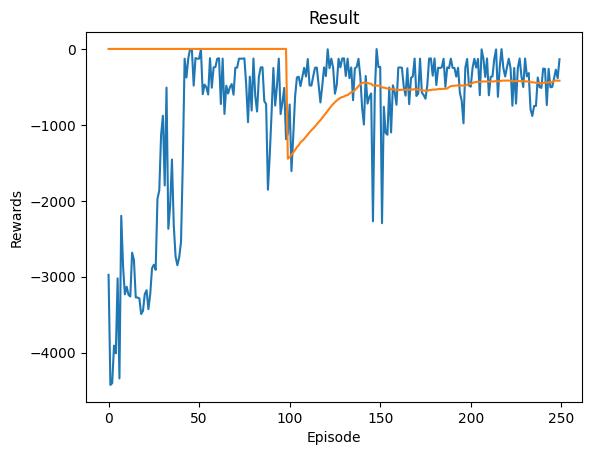

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [10]:
plot_durations(True)